<a href="https://colab.research.google.com/github/znoble360/cap4630/blob/master/HW_4/HW_4_P3_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Resources:

code derived from https://colab.research.google.com/drive/1F-RWvoxH8MmT7c1UmNy41iuOp-ejiLoF

# Fine-tuning Xception 

## Feature extraction

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-21 03:20:00--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   110MB/s    in 0.6s    

2020-04-21 03:20:01 (110 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with Xception convolution base and custom densely connected layers

### Load the convolutional base

In [4]:
from keras.applications import Xception

conv_base = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


83689472/83683744 [==============================] - 18s 0us/step


### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 33,969,193
Trainable params: 13,107,713
Non-trainable params: 20,861,480
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
10/10 [==============================] - 12s 1s/step - loss: 0.6885 - acc: 0.6500 - val_loss: 0.3232 - val_acc: 0.9340
Epoch 2/30
10/10 [==============================] - 4s 399ms/step - loss: 0.6334 - acc: 0.6600 - val_loss: 0.2987 - val_acc: 0.9190
Epoch 3/30
10/10 [==============================] - 4s 402ms/step - loss: 0.4247 - acc: 0.8550 - val_loss: 0.2372 - val_acc: 0.9440
Epoch 4/30
10/10 [==============================] - 4s 405ms/step - loss: 0.4021 - acc: 0.7700 - val_loss: 0.2760 - val_acc: 0.9230
Epoch 5/30
10/10 [==============================] - 4s 404ms/step - loss: 0.4267 - acc: 0.7900 - val_loss: 0.0660 - val_acc: 0.9460
Epoch 6/30
10/10 [==============================] - 4s 398ms/step - loss: 0.5561 - acc: 0.7250 - val_loss: 0.0532 - val_acc: 0.9370
Epoch 7/30
10/10 [==============================] - 4s 403ms/step - loss: 0.4118 - acc: 0.7900 - val_loss: 0.1266 - val_acc: 0

## Display curves of loss and accuracy during training

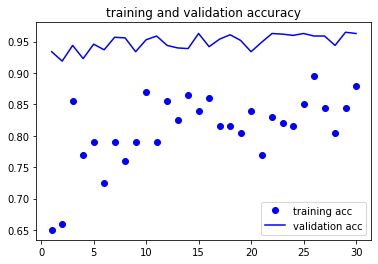

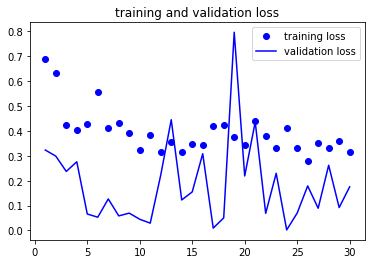

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [0]:
#conv_base.trainable = True
#
#set_trainable = False
#for layer in conv_base.layers:
#  if layer.name == 'block5_conv1':
#    set_trainable = True
#  if set_trainable:
#    layer.trainable = True
#  else:
#    layer.trainable = False

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block12_sepconv1_act':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  if layer.name == 'block12_sepconv3_bn':
    set_trainable = True
  else:
    layer.trainable = False

In [11]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
10/10 [==============================] - 7s 747ms/step - loss: 0.3365 - acc: 0.8550 - val_loss: 0.1842 - val_acc: 0.9600
Epoch 2/100
10/10 [==============================] - 4s 410ms/step - loss: 0.2658 - acc: 0.8950 - val_loss: 0.0113 - val_acc: 0.9560
Epoch 3/100
10/10 [==============================] - 4s 414ms/step - loss: 0.3134 - acc: 0.8300 - val_loss: 0.0191 - val_acc: 0.9530
Epoch 4/100
10/10 [==============================] - 4s 411ms/step - loss: 0.2819 - acc: 0.8900 - val_loss: 0.0303 - val_acc: 0.9530
Epoch 5/100
10/10 [==============================] - 4s 410ms/step - loss: 0.2909 - acc: 0.8450 - val_loss: 0.4912 - val_acc: 0.9480
Epoch 6/100
10/10 [==============================] - 4s 412ms/step - loss: 0.2891 - acc: 0.8600 - val_loss: 0.1548 - val_acc: 0.9460
Epoch 7/100
10/10 [==============================] - 4s 408ms/step - loss: 0.3193 - acc: 0.8500 - val_loss: 0.3897 - val_acc: 0.9300
Epoch 8/100
10/10 [==============================] - 4s 412ms/step - 

## Display learning curves during fine-tuning

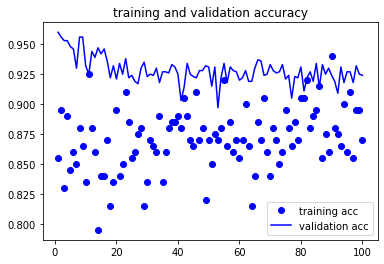

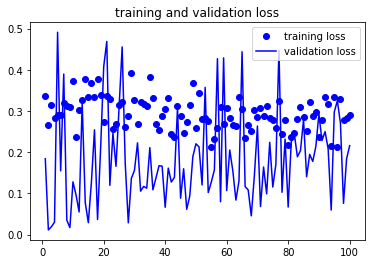

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [14]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.21596463024616241
Validation accuracy: 0.9240000247955322


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)